# 1. Load and parse the data
#### Code is primarily from Lydia's FICO-figures.ipynb 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# import all of our files
import sys
sys.path.append('../')
import Liu_paper_code.fico as fico
import Liu_paper_code.distribution_to_loans_outcomes as dlo
from scripts.data_creation_utils import get_pmf,get_repay_probabilities,get_scores, adjust_set_ratios,load_sample_and_save
from scripts.evaluation_utils import inspect_MinMax
from scripts.visualization_utils import visualize_data_distribution, visual_scores_by_race, visual_repay_dist
# imports for my own code
import pandas as pd
import random
from random import choices



In [3]:
# Parameters
data_dir = '../data/raw/'
results_dir = '../data/testing-timeit/'
file_name = 'test.csv'
set_size = 10000

group_size_ratio = [0.12,0.88]
black_label_ratio = [0.66,0.34]

order_of_magnitude = 100000
shuffle_seed = 42
round_num_scores = 2

In [4]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir);

In [5]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']
scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index


In [6]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
#group_ratio = np.array((totals["Black"], totals["White"]))
#group_size_ratio = group_ratio/group_ratio.sum() - true fico data goup size ratio
#print(group_size_ratio)

In [7]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# unpacking repay probability as a function of score
loan_repay_fns = [lambda x: loan_repaid_prob(x) for
                      loan_repaid_prob in loan_repaid_probs]

## 2.1 Convert the data in format needed
The parameter round_num designates if we will round the credit scores and/or probabilities to a certain degree.<br> 
round_num = {0,1,2} <br> 
* 0: don't round at all (we don't recommend this) <br>
* 1: round to the hundreth decimal <br>
* 2: round to the nearest integer (no decimals left)

In [8]:
# Make repay probabilities into percentages from decimals
# NOTE: A is Black, B is White
scores_arr = np.asarray(get_scores(scores=scores_list, round_num=round_num_scores)) # we recommend 1 or 2 for round_num
print(scores_arr)
repay_A_arr = pd.Series.to_numpy(repay_A)*100
repay_B_arr = pd.Series.to_numpy(repay_B)*100

[300. 312. 324. 336. 348. 355. 361. 367. 373. 379. 385. 390. 396. 402.
 406. 411. 416. 420. 425. 430. 434. 439. 444. 448. 452. 456. 460. 464.
 468. 472. 475. 479. 483. 487. 491. 495. 498. 502. 505. 508. 511. 515.
 518. 521. 524. 527. 530. 534. 537. 540. 543. 546. 549. 552. 555. 557.
 560. 562. 565. 568. 570. 573. 576. 578. 581. 583. 586. 589. 591. 594.
 596. 599. 601. 603. 605. 608. 610. 612. 614. 616. 618. 620. 622. 624.
 626. 628. 630. 632. 635. 637. 639. 641. 643. 645. 647. 649. 651. 653.
 655. 657. 658. 660. 662. 664. 666. 667. 669. 671. 673. 675. 676. 678.
 680. 682. 684. 686. 687. 689. 691. 693. 695. 696. 698. 700. 701. 703.
 704. 706. 707. 709. 710. 712. 713. 715. 716. 718. 719. 721. 722. 724.
 725. 726. 728. 729. 731. 734. 735. 737. 738. 740. 741. 743. 744. 746.
 749. 750. 752. 753. 755. 756. 758. 759. 761. 763. 764. 766. 767. 769.
 771. 772. 774. 775. 777. 778. 780. 782. 783. 785. 786. 788. 790. 791.
 793. 796. 797. 799. 802. 806. 811. 815. 819. 824. 828. 832. 837. 841.
 846. 

## 2.2 Sample from the data and Combine the scores and probabilities and convert data types
We use round_num with a value of 1 so that we have two decimals for the probabilities. We think rounding to the nearest integer would lead to us losing important data. 

In [21]:
def sample(group_size_ratio, order_of_magnitude, shuffle_seed,scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr):
    
        # Sample data according to the pmf
    # Reference: https://www.w3schools.com/python/ref_random_choices.asp

    num_A_samples = int(round(group_size_ratio[0] * order_of_magnitude))
    num_B_samples = int(round(group_size_ratio[1] * order_of_magnitude))

    samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
    samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

    # Calculate samples groups' probabilities and make arrays for race

    # A == Black == 0 (later defined as 0.0 when converting to pandas df)
    samples_A_probs = get_repay_probabilities(samples=samples_A,scores_arr=scores_arr, repay_probs=repay_A_arr, round_num=1)
    samples_A_race = np.zeros(num_A_samples, dtype= int)
    # B == White == 1 (later defined as 1.0 when converting to pandas df)
    samples_B_probs = get_repay_probabilities(samples=samples_B,scores_arr=scores_arr, repay_probs=repay_B_arr, round_num=1)
    samples_B_race = np.ones(num_B_samples, dtype= int)

    # Get data in dict form with score and repay prob
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs} #,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs} #,'race': samples_B_race}

    # Get data in dict form with score, repay prob, and race
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs ,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs,'race': samples_B_race}

    # Convert from dict to df
    data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
    data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

    # Combine all of the data together and shuffle
    # NOTE: not currently being used but could be useful at a later time
    data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
    #print(data_all_df)
    np.random.seed(shuffle_seed)
    data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
    #print(data_all_df_shuffled)

    # Add Final Column to dataframe, repay indices
    # repay: 1.0, default: 0.0
    probabilities = data_all_df_shuffled['repay_probability']
    repay_indices = []
    # Create a random num and then have that decide given a prob if the person gets a loan or not
    # (e.g. If 80% prob, then calculate a random num, then if that is below they will get loan, if above, then they don't)

    for index, prob in enumerate(probabilities):
        rand_num = random.randint(0,1000)/10
        if rand_num > prob:  # default
            repay_indices.append(0)
        else:
            repay_indices.append(1)  # repay

    data_all_df_shuffled['repay_indices'] = np.array(repay_indices)

    return data_all_df_shuffled, samples_A, samples_B, samples_A_probs, samples_B_probs

In [11]:
# Sample data according to the pmf
# Reference: https://www.w3schools.com/python/ref_random_choices.asp
# Calculate samples groups' probabilities and make arrays for race
# A == Black == 0 (later defined as 0.0 when converting to pandas df)
# B == White == 1 (later defined as 1.0 when converting to pandas df)

# generate first batch of samples:
data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample(group_size_ratio, order_of_magnitude,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
# split the data cols (x,y)

x = data[['score','repay_probability', 'race']].values
y = data['repay_indices'].values
print(len(y))
# adjust the set according to the ratios specified
x,y = adjust_set_ratios(x, y, black_label_ratio, group_size_ratio, set_size)
idx_An = np.where((x[:, 2] == 0) & (y == 0))[0]
idx_Ap = np.where((x[:, 2] == 0) & (y == 1))[0]
idx_B = np.where((x[:, 2] == 1))[0]
i = 1
# merge x,y back into a DataFrame
df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
data = pd.DataFrame(df)
print(data)
# if dataset it to small, samplee a larger batch
while len(y) < set_size:
    i += 1
    print('I',i)
    # Generate new samples
    data_add, samples_A_add, samples_B_add, samples_A_probs_add, samples_B_probs_add = sample(group_size_ratio, order_of_magnitude,i, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    data = pd.concat([data,data_add])
    samples_A = np.concatenate((samples_A,samples_A_add))
    samples_A_probs = np.concatenate((samples_A_probs,samples_A_probs_add))
    samples_B = np.concatenate((samples_B,samples_B_add))
    samples_B_probs = np.concatenate((samples_B_probs,samples_B_probs_add))
    # split the data cols (x,y)
    x = data[['score','repay_probability', 'race']].values
    y = data['repay_indices'].values
    # adjust the set according to the ratios specified
    print(len(y))
    x,y = adjust_set_ratios(x,y, black_label_ratio, group_size_ratio, set_size)
    print(len(y))
    # merge x,y back into a DataFrame
    if len(y) >= set_size:
        idx_An = np.where((x[:, 2] == 0) & (y == 0))[0]
        idx_Ap = np.where((x[:, 2] == 0) & (y == 1))[0]
        idx_B = np.where((x[:, 2] == 1))[0]
        df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
        data = pd.DataFrame(df)
# print proportions of dataset
print(i,'Black N/P:',len(idx_An),'/',len(idx_Ap),'White:',len(idx_B))

1
   score  repay_probability  race  repay_indices
0  783.0              98.51   1.0              1
1 Black N/P: 0 / 0 White: 1


In [12]:
# fixed |D|, flexible |S| -> linear O(n), no slope O(|D|) when |S| > |D|
# fixed |S|, flexible |D| -> linear O(n)
# flexible |D| = |S| -> linear O(n)
group_size_ratio = [0.88,0.12]
black_label_ratio = [0.34,0.66]
data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample([0.12,0.88], 100000,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)

x = data[['score','repay_probability', 'race']].values
y = data['repay_indices'].values

x_points = []
timings = []
for i in range(0,1000000, 100000):
    print(i)
    x_points.append(i)
    data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample([0.12,0.88], i*2,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    x = data[['score','repay_probability', 'race']].values
    y = data['repay_indices'].values
    runtime = %timeit -o adjust_set_ratios(x,y, black_label_ratio, group_size_ratio, i)
    timings.append(runtime.average)
    print(runtime.average)
    

0
37.7 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
3.774947285714271e-05
100000
5.09 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0.005092473714285696
200000
9.25 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0.009250750571428575
300000
14.8 ms ± 840 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

KeyboardInterrupt: 

In [ ]:
plt.plot(x_points, timings) 

In [ ]:
# flexible |D| -> linear O(n)
group_size_ratio = [0.12,0.88]
x_points = []
timings = []
for i in range(0,100000, 10000):
    print(i)
    x_points.append(i)
    runtime = %timeit -o sample(group_size_ratio, i,i, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    timings.append(runtime.average)
    print(runtime.average)
    

In [ ]:
plt.plot(x_points, timings) 

In [ ]:
# label distributions fixed
# fixed |D|, flexible |S| -> if |D| > |S| linear O(n)
# fixed |S|, flexible |D| ->  linear O(n), exponential decay O(1/2^-n) when |S| >= |D|
# flexible |D| = |S| -> linear O(n)
# label distribution flexibel 
#|D| = |S| linear (with dip)
#|D| > |S| linear (with 2 dips)
#|D| < |S| linear (with dip)
group_size_ratio = [0.99,0.01]
black_label_ratio = [0.01,0.99]
x_points = []
timings = []

for j in np.arange(0.0,1.0, 0.1):
    print(j)
    x_points.append(j)
    runtime = %timeit -o load_sample_and_save(data_dir, results_dir+file_name, 100, [j,1.0-j], [j,1.0-j], 1000, round_num_scores, shuffle_seed)

    timings.append(runtime.average)
    print(runtime.average)


In [ ]:
plt.plot(x_points, timings) 

## Space Complexity runs

In [9]:
def sample_s(group_size_ratio, order_of_magnitude, shuffle_seed,scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr):
    
        # Sample data according to the pmf
    # Reference: https://www.w3schools.com/python/ref_random_choices.asp
    space = 0
    num_A_samples = int(round(group_size_ratio[0] * order_of_magnitude))
    num_B_samples = int(round(group_size_ratio[1] * order_of_magnitude))
    
    
    samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
    samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

    
    # Calculate samples groups' probabilities and make arrays for race

    # A == Black == 0 (later defined as 0.0 when converting to pandas df)
    samples_A_probs = get_repay_probabilities(samples=samples_A,scores_arr=scores_arr, repay_probs=repay_A_arr, round_num=1)
    samples_A_race = np.zeros(num_A_samples, dtype= int)
    # B == White == 1 (later defined as 1.0 when converting to pandas df)
    samples_B_probs = get_repay_probabilities(samples=samples_B,scores_arr=scores_arr, repay_probs=repay_B_arr, round_num=1)
    samples_B_race = np.ones(num_B_samples, dtype= int)

    # Get data in dict form with score and repay prob
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs} #,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs} #,'race': samples_B_race}

    # Get data in dict form with score, repay prob, and race
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs ,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs,'race': samples_B_race}


    # Convert from dict to df
    data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
    data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

    # Combine all of the data together and shuffle
    # NOTE: not currently being used but could be useful at a later time
    data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
    #print(data_all_df)

    np.random.seed(shuffle_seed)
    data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
    #print(data_all_df_shuffled)

    # Add Final Column to dataframe, repay indices
    # repay: 1.0, default: 0.0
    probabilities = data_all_df_shuffled['repay_probability']
    repay_indices = []
    # Create a random num and then have that decide given a prob if the person gets a loan or not
    # (e.g. If 80% prob, then calculate a random num, then if that is below they will get loan, if above, then they don't)

    for index, prob in enumerate(probabilities):
        rand_num = random.randint(0,1000)/10
        
        if rand_num > prob:  # default
            repay_indices.append(0)
        else:
            repay_indices.append(1)  # repay
            
    data_all_df_shuffled['repay_indices'] = np.array(repay_indices)
    
    space = sys.getsizeof(num_A_samples) + sys.getsizeof(num_B_samples) +sys.getsizeof(samples_A)
    +sys.getsizeof(samples_B)+sys.getsizeof(samples_A_probs)+sys.getsizeof(samples_B_probs)
    +sys.getsizeof(samples_A_race)+sys.getsizeof(samples_B_race)+sys.getsizeof(data_A_dict)
    +sys.getsizeof(data_B_dict)+sys.getsizeof(data_all_df)+sys.getsizeof(data_B_df)
    +sys.getsizeof(data_A_df)+sys.getsizeof(repay_indices)+sys.getsizeof(probabilities)+ sys.getsizeof(data_all_df_shuffled)
    
    return space, data_all_df_shuffled, samples_A, samples_B, samples_A_probs, samples_B_probs

In [10]:
def adjust_set_ratios_s(x_data, y_data, label_ratio, race_ratio, set_size_upper_bound):
    """
    Changes the proportions of samples in the set. Proportion of each group (race) and proportion of labels for the Black (0) group.
        Args:
            - x_data <numpy.ndarray>: ['score','repay_probability','race'] -> array of samples
            - y_data <numpy.ndarray>: ['repay_indices'] -> array of samples
            - label_ratio <list<float>>: contains two 2 floats between 0 and 1 (sum = 1), representing the ratio of samples with each labels for the black group (False,True)
            - race_ratio <list<float>>: contains two 2 floats between 0 and 1 (sum = 1), representing the ratio of black to white samples generated (Black,White)
            - set_size_upper_bound <int>: absolute upper bound of the size for the dataset (e.g 100,000)
        Returns:
            subset of x_data and y_data
    """
    # Black = 0; White = 1
    # limits the absolute test_size if necessary
    if len(y_data) > set_size_upper_bound:
        set_size = set_size_upper_bound
    else:
        set_size = len(y_data)

    num_0 = int(round(set_size * race_ratio[0]))
    num_1 = int(round(set_size * race_ratio[1]))

    # number of samples for the Black group, according to the label ratio
    num_0P = int(round(num_0 * label_ratio[1]))
    num_0N = int(round(num_0 * label_ratio[0]))
    num_1P = int(round(num_1 * 0.76))
    num_1N = int(round(num_1 * 0.24))
    

    
    # getting the indices of each samples for each group
    idx_0N = np.where((x_data[:, 2] == 0) & (y_data == 0))[0]
    idx_0P = np.where((x_data[:, 2] == 0) & (y_data == 1))[0]

    idx_1N = np.where((x_data[:, 2] == 1) & (y_data == 0))[0]
    idx_1P = np.where((x_data[:, 2] == 1) & (y_data == 1))[0]
    
    space = sys.getsizeof(set_size) + sys.getsizeof(num_0) +sys.getsizeof(num_1)
    +sys.getsizeof(num_0N)+sys.getsizeof(num_0P)+sys.getsizeof(num_1N)
    +sys.getsizeof(num_1P)+sys.getsizeof(idx_0N)+sys.getsizeof(idx_0P)
    +sys.getsizeof(idx_1N )+sys.getsizeof(idx_1P)
    
    # if group size numbers are larger than the available samples for that group adjust it
    if len(idx_0P) < num_0P:
        num_0P = len(idx_0P)
        num_0N = int(round(num_0P/label_ratio[1] * label_ratio[0]))
        num_1P =  int(round((num_0N + num_0P)/race_ratio[0] * race_ratio[1] * 0.76))
        num_1N =  int(round((num_0N + num_0P)/race_ratio[0] * race_ratio[1] * 0.24))
    if len(idx_0N) < num_0N:
        num_0N = len(idx_0N)
        num_0P = int(round(num_0N/label_ratio[0] * label_ratio[1]))
        num_1P =  int(round((num_0N + num_0P)/race_ratio[0] * race_ratio[1] * 0.76))
        num_1N =  int(round((num_0N + num_0P)/race_ratio[0] * race_ratio[1] * 0.24))
    if len(idx_1P) < num_1P:
        num_1P = len(idx_1P)
        num_1N = int(round(num_1P/0.76 * 0.24))
        num_0P =  int(round((num_1N + num_1P)/race_ratio[1] * race_ratio[0] * label_ratio[1]))
        num_0N =  int(round((num_1N + num_1P)/race_ratio[1] * race_ratio[0] * label_ratio[0]))
    if len(idx_1N) < num_1N:
        num_1N = len(idx_1N)
        num_1P = int(round(num_1N/0.24 * 0.76))
        num_0P =  int(round((num_1N + num_1P)/race_ratio[1] * race_ratio[0] * label_ratio[1]))
        num_0N =  int(round((num_1N + num_1P)/race_ratio[1] * race_ratio[0] * label_ratio[0]))
    # adjusting racio distrubution as well


    # take the amount of samples, by getting the amount of indices
    idx_0N = idx_0N[:num_0N]
    idx_0P = idx_0P[:num_0P]
    idx_1N = idx_1N[:num_1N]
    idx_1P = idx_1P[:num_1P]
    # concatenate indices
    idx = sorted(np.concatenate((idx_0N,idx_0P,idx_1N,idx_1P)))
    
    space += sys.getsizeof(idx)

    
    return space, x_data[idx,:], y_data[idx]

In [14]:
def loop_s(group_size_ratio,black_label_ratio, order_of_magnitude,set_size, shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr):
    # Sample data according to the pmf
    # Reference: https://www.w3schools.com/python/ref_random_choices.asp
    # Calculate samples groups' probabilities and make arrays for race
    # A == Black == 0 (later defined as 0.0 when converting to pandas df)
    # B == White == 1 (later defined as 1.0 when converting to pandas df)
    space = 0
    # generate first batch of samples:
    s, data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample_s(group_size_ratio, order_of_magnitude,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    # split the data cols (x,y)
    space += s
    space += sys.getsizeof(data)
    space += sys.getsizeof(samples_A)
    space += sys.getsizeof(samples_B)
    space += sys.getsizeof(samples_A_probs)
    space += sys.getsizeof(samples_B_probs)

    x = data[['score','repay_probability', 'race']].values
    y = data['repay_indices'].values
    space += sys.getsizeof(x)
    space += sys.getsizeof(y)
    # adjust the set according to the ratios specified
    s,x,y = adjust_set_ratios_s(x, y, black_label_ratio, group_size_ratio, set_size)
    space += sys.getsizeof(x)
    space += sys.getsizeof(y)
    space += s
    i = 1
    # merge x,y back into a DataFrame
    df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
    data = pd.DataFrame(df)
    space += sys.getsizeof(df)
    space += sys.getsizeof(data)
    # if dataset it to small, samplee a larger batch
    while len(y) < set_size:
        i += 1
        # Generate new samples
        s, data_add, samples_A_add, samples_B_add, samples_A_probs_add, samples_B_probs_add = sample_s(group_size_ratio, order_of_magnitude,i, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
        data = pd.concat([data,data_add])

        space += s
        space += sys.getsizeof(data)
        space += sys.getsizeof(data_add)
        space += sys.getsizeof(samples_A_add)
        space += sys.getsizeof(samples_B_add)
        space += sys.getsizeof(samples_A_probs_add)
        space += sys.getsizeof(samples_B_probs_add)

        samples_A = np.concatenate((samples_A,samples_A_add))
        samples_A_probs = np.concatenate((samples_A_probs,samples_A_probs_add))
        samples_B = np.concatenate((samples_B,samples_B_add))
        samples_B_probs = np.concatenate((samples_B_probs,samples_B_probs_add))

        space += sys.getsizeof(samples_A)
        space += sys.getsizeof(samples_B)
        space += sys.getsizeof(samples_A_probs)
        space += sys.getsizeof(samples_B_probs)
        # split the data cols (x,y)
        x = data[['score','repay_probability', 'race']].values
        y = data['repay_indices'].values
        # adjust the set according to the ratios specified
        space += sys.getsizeof(x)
        space += sys.getsizeof(y)
        s,x,y = adjust_set_ratios_s(x,y, black_label_ratio, group_size_ratio, set_size)
        space += s
        space += sys.getsizeof(x)
        space += sys.getsizeof(y)

    # merge final x,y back into a DataFrame
    df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
    data = pd.DataFrame(df)
    space += sys.getsizeof(df)
    space += sys.getsizeof(data)

    return space, data


In [24]:
# flexible |D| -> linear O(n)
group_size_ratio = [0.5,0.5]
order_of_magnitude = 10000

# flexible |D| -> linear O(n)
group_size_ratio = [0.12,0.88]
x_points = []
spaces = []
for i in range(0,100000, 10000):
    x_points.append(i)
    space,_,_,_,_,_ = sample_s(group_size_ratio, i,i, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    spaces.append(space)
    


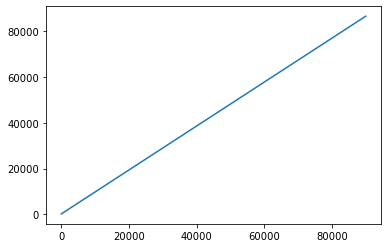

In [25]:
plt.plot(x_points, spaces) 

In [ ]:
group_size_ratio = [0.12,0.88]
black_label_ratio = [0.66,0.34]
#_, data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample_s([0.12,0.88], 100000,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)

x_points = []
spaces = []
for i in range(0,100000, 1000):
    x_points.append(i)
    
    _, data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample_s([0.12,0.88], i,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    x = data[['score','repay_probability', 'race']].values
    y = data['repay_indices'].values
    #space = sys.getsizeof(x)+ sys.getsizeof(y)
    space,_,_ = adjust_set_ratios_s(x,y, black_label_ratio, group_size_ratio,10000)
    spaces.append(space)

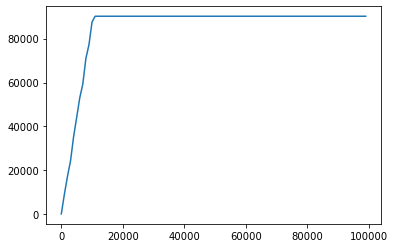

In [54]:
plt.plot(x_points, spaces) 

In [31]:
# fixed |D|, flexible |S| -> A: linear O(n) 
# fixed |S|, flexible |D| ->  o(n) 
# flexible |D| = |S| -> A: linear O(n)
group_size_ratio = [0.12,0.88]
black_label_ratio = [0.66,0.34]
order_of_magnitude = 1000
set_size = 100

x_points = []
spaces = []
for i in range(1000,100000, 1000):
    x_points.append(i)
    
    space,_ = loop_s(group_size_ratio,black_label_ratio, i, 1000,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    spaces.append(space)
    

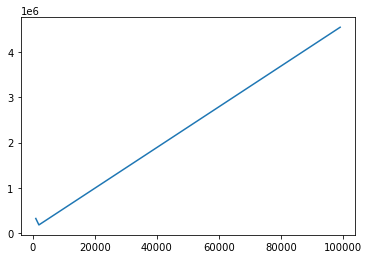

In [32]:
plt.plot(x_points, spaces) 

## 2.4 Save the pandas dataframes to CSVs

In [ ]:
data.to_csv(index=False, path_or_buf=results_dir+file_name)

# To save the data separately by race
#data_A_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupA_black.csv')
#data_B_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupB_white.csv')

## 2.5 Inspect the min/max values of the data

In [ ]:
# TODO: make a function for printing the min/max values of the respective groups for score and probability

In [ ]:
inspect_MinMax(samples_A_probs,samples_B_probs)

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

total_samples_A = len(samples_A)
total_samples_B = len(samples_B)
values_A = set(samples_A)
values_B = set(samples_B)
res_A = Counter(samples_A)
res_B = Counter(samples_B)

pmf_A = []
pmf_B = []
for v_A,v_B in zip(values_A,values_B):
    pmf_A.append(res_A[v_A]/total_samples_A)
    pmf_B.append(res_B[v_B]/total_samples_B)
    

count1 = 0
count2 = 0
for e1,e2 in zip(pmf_A,pmf_B):
    if e1 < 1/550:
        count1 += 1
    if e2 < 1/550:
        count2 += 1
    
print('Ratio:',count1/len(pmf_A), count2/len(pmf_B))

In [ ]:
### Masuring the amount of points <1%
count1 = 0
count2 = 0
for e1,e2 in zip(samples_A_probs,samples_B_probs):
    if e1 < 1:
        count1 += 1
    if e2 < 1:
        count2 += 1
    
print('Ratio:',count1/len(samples_A_probs), count2/len(samples_B_probs))

## 2.6 Visualize the data

In [ ]:
visualize_data_distribution(results_dir,samples_A,samples_A_probs,samples_B,samples_B_probs)

In [ ]:
#visual_scores_by_race(data)

In [ ]:
#visual_repay_dist(data)